# 5 clusters
# min=100 cases per cluster
# min start similarity 95%
# seauence matcher similarity 6 minutes

# Table of contents:
# 1- Similarity
# 1- Clustering
# 1- Model discovery --> alignment --> fitness -->presect clusters
# 1- outcome prediction(1)  89.6% AUC
# 1- Remaining time prediction (BETA)
# 1- Centroid based predict clusters 
# 1- outcome prediction (2)  90% AUC


In [1]:
import pandas as pd
import time
import numpy as np
import pickle
#from ClusteringPredictiveModel import ClusteringPredictiveModel
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import difflib as diff
from pm4py.objects.log.importer.xes import factory as xes_importer
import random

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\pm4py\visualization\graphs\versions\cases.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\MSI\Miniconda3\envs

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\pm4py\visualization\intervaltree\versions\classic.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\MSI\Minicon

In [2]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [3]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = "Complete Timestamp"
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['Resource','(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=["Complete Timestamp",'Start Timestamp','EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [4]:
data.drop(meta_event_data,axis=1,inplace=True)
#data.drop(variant_col,axis=1,inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['Activity'] = lb_make.fit_transform(data['Activity'])

data.head() #Results in appending a new column to df

Case ID  Activity Resource  Variant index  \
0  Application_652823628         4   User_1              2   
1  Application_652823628         8   User_1              2   
2  Application_652823628         3   User_1              2   
3  Application_652823628        20  User_17              2   
4  Application_652823628         0  User_52              2   

  (case) ApplicationType         (case) LoanGoal  (case) RequestedAmount  \
0             New credit  Existing loan takeover                 20000.0   
1             New credit  Existing loan takeover                 20000.0   
2             New credit  Existing loan takeover                 20000.0   
3             New credit  Existing loan takeover                 20000.0   
4             New credit  Existing loan takeover                 20000.0   

         lbl  
0  A_Pending  
1  A_Pending  
2  A_Pending  
3  A_Pending  
4  A_Pending

In [6]:
lb_make.classes_

array(['A_Accepted', 'A_Cancelled', 'A_Complete', 'A_Concept',
       'A_Create Application', 'A_Denied', 'A_Incomplete', 'A_Pending',
       'A_Submitted', 'A_Validating', 'O_Accepted', 'O_Cancelled',
       'O_Create Offer', 'O_Created', 'O_Returned',
       'O_Sent (mail and online)', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Call after offers',
       'W_Call incomplete files', 'W_Complete application',
       'W_Handle leads', 'W_Personal Loan collection',
       'W_Shortened completion', 'W_Validate application'], dtype=object)

# ===================

In [7]:
# divide into train and test data
np.random.seed(22)
sample_cases_KMedoide = np.random.choice(data[case_id_col].unique(), len(data[case_id_col].unique()))
train_cases_KMedoide, test_cases_KMedoide = train_test_split(sample_cases_KMedoide , train_size = 4.0/5, random_state = 22 )
train_KMedoide = data[data[case_id_col].isin(train_cases_KMedoide)]
test_KMedoide = data[data[case_id_col].isin(test_cases_KMedoide)]

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# listing all variants
grouping=train_KMedoide.groupby(['Case ID']).apply(lambda x:(x.head(1)))
unique_variants=list(grouping.groupby(['Variant index']).head(1)['Case ID'])
uniques=train_KMedoide[train_KMedoide['Case ID'].isin (unique_variants)]

In [10]:
# encoding the sequence which represent each variant

def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = uniques.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_train = grouped.apply(lambda x: trace(x) )

In [11]:
label = uniques.groupby(['Case ID'],sort=False).first()['lbl']

In [12]:
# labeling variants  nb. dont care about Case ID is is just an example!
ac_lbl=pd.DataFrame(columns=['Case ID','Activity','lbl','Variant'])
ac_lbl['Case ID']=Activities_train.index
ac_lbl['Activity']=list(Activities_train)
ac_lbl['lbl']=list(label)
ac_lbl['Variant']=list(uniques['Variant index'].unique())
ac_lbl.head()

Case ID                    Activity          lbl  Variant
0  Application_1018615109        ¥©¤µ¡­®­®°°³£¹ª¯´§«¨    A_Pending       49
1   Application_196483749        ¥µ¤¡­®±³£¬­®°­®°­®°¢  A_Cancelled     1124
2  Application_1699757505  ¥©¤µ¡­®±³£­®°­®°¬¹ª¯´§¹ª«¨    A_Pending     1126
3  Application_1825104006     ¥©¤µ¡­®­®°°³£­®­®°°­®°¢  A_Cancelled      798
4  Application_1405679737       ¥©¤µ¡­®°³£¹ª¯´§¹ª¹´§¢  A_Cancelled     1128

# ==================Recommendation system techniques========

# functions:

In [12]:
def getGramsNumber(string, q):
    return (len(string) + (q - 1) * 2 + 1) - q

In [13]:
def getUnNormalisedSimilarity(s1, s2, q):
    difference = 0
    array3temp=[]
    array3temp.extend(s1)
    array3temp.extend(s2)
    #array3=array3temp
    array3 = np.unique(array3temp)
    
    for i  in range(len(array3)):
        token = array3[i]
        matchingQGrams1 = s1.count(token)
        matchingQGrams2 = s2.count(token)
        if matchingQGrams1 > matchingQGrams2 :
            difference += matchingQGrams1 - matchingQGrams2
        else:
            difference += matchingQGrams2 - matchingQGrams1
    return difference

In [14]:
# function of q_grams_similarity

def q_grams_similarity(string1, string2, q):
    array1_steps = getGramsNumber(string1, q)
    array2_steps = getGramsNumber(string2, q)
    maxQGramsMatching = array1_steps + array2_steps
    if (maxQGramsMatching == 0):
        return 0.00;
    else :
        return (maxQGramsMatching - getUnNormalisedSimilarity(string1, string2, q)) / maxQGramsMatching
            
    

In [13]:
#This function returns the symmetric matrix associated to a triangular matrix
#It returns a matrix
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

$$Cluster_{k}AverageIntraSimilarity=CAIS_{k}=\dfrac{\sum_{i=0}^{m_k}S(i,CC_k)}{m_k}$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [14]:
#This function computes the average intra-similarity of a cluster
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterAvgSimilarity(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList): #Generate list of users in the cluster (medoid included)
        if (i==clusterMedoidID):
                clusterMembers.append(count)     
   
    tempSumOfSim=0
    for i in clusterMembers: #Sum the similarities between members and cluster medoid
            tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    avgClusterSimilarity=tempSumOfSim/(len(clusterMembers)) #Divide the sum by the number of users in cluster in order to get the average
        
    return avgClusterSimilarity

$$Cluster_{k}SimilaritySumWithCenter=\sum_{i=0}^{m_k}S(i,CC_k)$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [15]:
#This function is the same as calculateClusterAvgSimilarity() except it doesn't average the final sum
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterSimilaritySumWithCenter(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList):
        if (i==clusterMedoidID):
            clusterMembers.append(count)
            
    tempSumOfSim=0
    for i in clusterMembers:
        tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    
    return tempSumOfSim

$$r_l=\dfrac{\sum_{i=0}^{N}S(i,CC_0) }{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}$$

<center>Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid, $N$ is the number of users, $CC_{0}$ is the first medoid</center>

$r_{l}$ is the ratio between the sum of the current clusters average intra-similarities and the original cluster average intra-similarity $\rightarrow$ Indicate how we are increasing/decreasing the intra-similarity in our system in comparasion with the original state

In [16]:
#This function computes RL ratio defined above
#It returns a float

#N_l = number of cluster at iteration l
#N = total number of users
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 


# clusterMedoidID = int : ID of the medoid of the cluster
# gamma0 = float : Sum of similarities between objects cluster medoid at the origin
# similarities = array : Similarity matrix
def calculateSimilarityRatioRL(clusterList,similarities,gamma0):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
        
    similarityRatioRL=gamma0/systemSimilaritySum
    #similarityRatioRL=systemSimilaritySum/gamma0 #Old version of the criterion
    
    return similarityRatioRL

$$\gamma_l=\dfrac{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}{N_l}$$

Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid

In [17]:
#This function computes GammaL ratio defined in paper
#It returns a float

#N_l = number of cluster at iteration l
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 

# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix
def calculateGammaL(clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
    
    gammaL=systemSimilaritySum/len(clusters)
    return gammaL

###  Generate similarity matrix

In [18]:
numberOfUsers=Activities_train.shape[0]

In [19]:
Activities_train.shape

(2613,)

In [20]:

start = time.time()
similarities=np.zeros([numberOfUsers,numberOfUsers])
for i in range(numberOfUsers) :
    clear_output(wait=True)
    print("Calculating similarities for : ",i, end='\r')
    
    for j in range(numberOfUsers) :
        if j>i: #Only generate the lower triangular values
            break
        elif i==j:
            similarities[i][j]=1
        else :
            similarities[i][j]= (diff.SequenceMatcher ( None,Activities_train[i],Activities_train[j]).ratio())
                                
end = time.time()
print("Elapsed time : ",end - start)

Elapsed time :  397.0278525352478612


In [21]:
#Symmetrize the matrix as we only computed the lower triangular values
similarities=symmetrize(similarities)

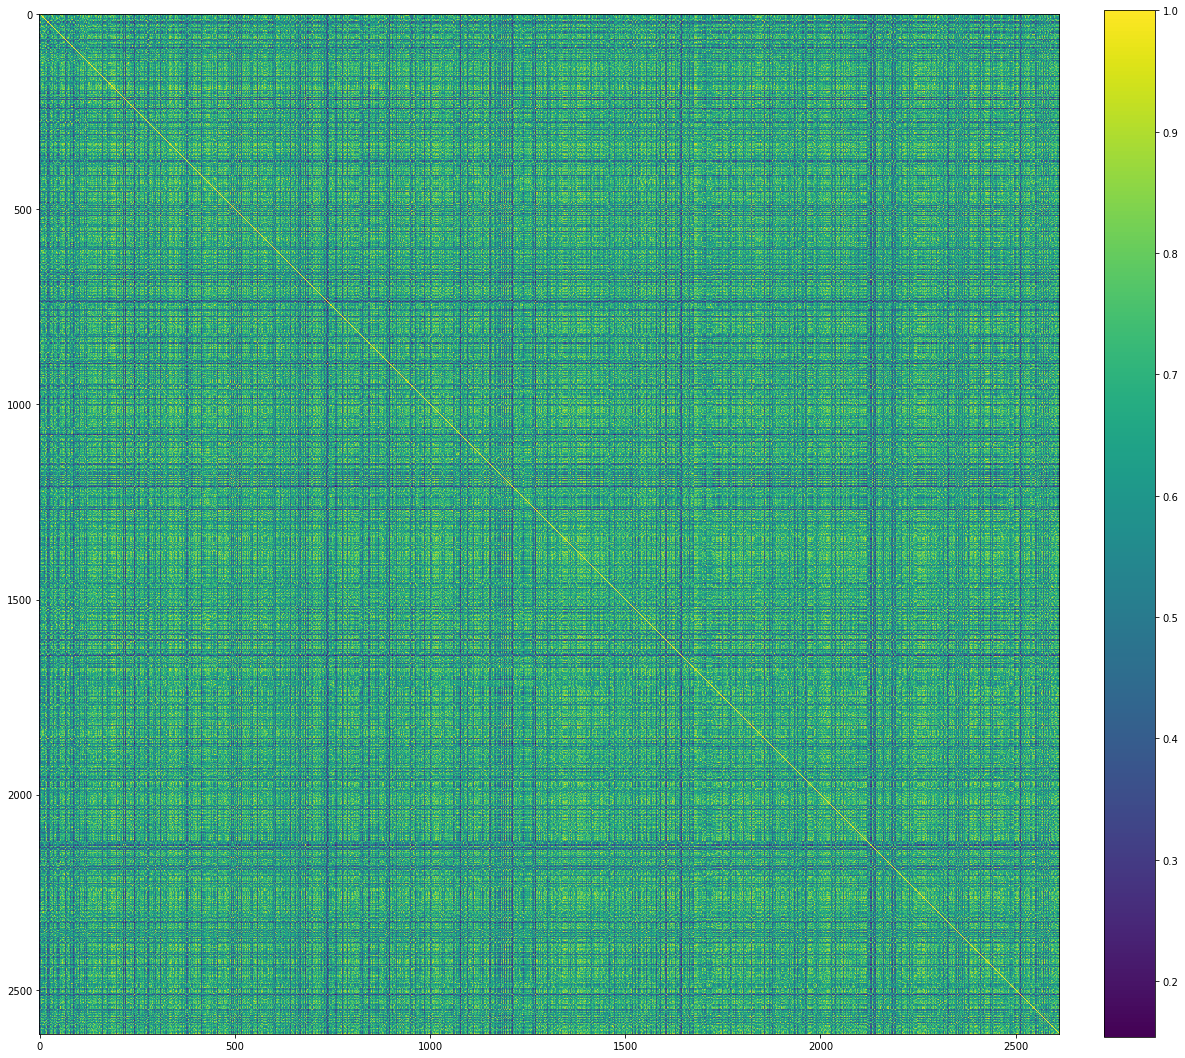

In [22]:
plt.figure(1, figsize=(20,20))
heatmap=plt.imshow(similarities, cmap='viridis', interpolation='nearest')
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

### Initialize the clustering algorithm

In [255]:
nL=0 #number of cluster at iteration l
CCS=[] #List of Medoids
clusterList=np.zeros((numberOfUsers,)) #List of cluster assignation
sumOfSim=np.zeros((numberOfUsers,)) #Sum of similarities columns
rL_history=[] #History of RL ratio
ratioNL_history=[] #History of NL ratio
gammaL_history=[] #History of GammaL ratio
sumRLNL=[] #History of rL+NL

In [256]:
#Calculate sum of similarities for each column | Once calculated, it doesn't change and is, thus, re-usable
for i in range(numberOfUsers) :
    tempSum=np.sum(similarities[:,i])
    sumOfSim[i]=tempSum

In [257]:
#Get the most similar and least similar object to others (=> First two medoids)
maxOfSumSim=np.amax(sumOfSim)
indexMax=np.argmax(sumOfSim)
minOfSumSim=np.amin(sumOfSim)
indexMin=np.argmin(sumOfSim)

for i in range(numberOfUsers): #Firstly, we only assign all the items to the medoids with the highest sum of similarities with others (Genesis cluster)
    clusterList[i]=indexMax

nL+=1 #Add one to n° of cluster cause there's one global cluster (but add nothing to CCS as this first assignement is only to compute Gamma0) and assign everyone to genesis cluster (the one with the biggest SumOfSim)

gamma0=maxOfSumSim #For stop condition used later

#Compute system ratios for the genesis cluster
#tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("Genesis RL :",tempRatioRL,"| Genesis Ratio NL :",tempRatioNL,"| Genesis RL + Ratio NL :",tempSumRLNL,"| Genesis GammaL (=Gamma0) :",tempGammaL)
print("Max in",indexMax,":",maxOfSumSim,"| Min in",indexMin,":",minOfSumSim," | Gamma0 is :",gamma0)

#Add the two medoids to initizialize the bissecting process
CCS.append(indexMax)
CCS.append(indexMin)
nL+=1 #Only increase by one because we have delete the genesis cluster and add two new cluster => 1-1+2=2

Genesis RL : 0.9999999999999962 | Genesis Ratio NL : 0.0003827018752391887 | Genesis RL + Ratio NL : 1.0003827018752354 | Genesis GammaL (=Gamma0) : 1915.3786486175727
Max in 1996 : 1915.3786486175654 | Min in 2298 : 871.4282454231272  | Gamma0 is : 1915.3786486175654


In [258]:
#Assign every object to the good cluster
for i in range(numberOfUsers):
    similarityWithMax=similarities[i,indexMax]
    similarityWithMin=similarities[i,indexMin]

    #if similarityWithMax>similarityWithMin:
    if   similarityWithMax>0.95 and   similarityWithMax>similarityWithMin : # for excluding even other high similarity item
        clusterList[i]=indexMax
    else:
        clusterList[i]=indexMin

In [259]:
#Compute system ratios 
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("First2 clusters RL :",tempRatioRL,"| First2 clusters Ratio NL :",tempRatioNL,"| First2 clusters RL + Ratio NL :",tempSumRLNL,"| First2 clusters GammaL (=Gamma0) :",tempGammaL)

First2 clusters RL : 2.1622227767403133 | First2 clusters Ratio NL : 0.0007654037504783774 | First2 clusters RL + Ratio NL : 2.1629881804907916 | First2 clusters GammaL (=Gamma0) : 442.91889559713155


In [260]:
print("Current clustering state :")
clusters, countsClusters=np.unique(clusterList, return_counts=True)
print("Clusters :",clusters)
print("Counts :",countsClusters)

Current clustering state :
Clusters : [1996. 2298.]
Counts : [  22 2591]


### Looping the algorithm until convergence

In [261]:
debug=False
#numberOfClusterStop=len(clusterList) #Cluster number simple condition
numberOfClusterStop=10

In [262]:
isOver=False
oldCCS=[]
oldClusterlist=[]
#previous_state_clusters_count=[]
#previous_state_clusters=[]

while(isOver==False):

    #'''
    cs=[list(clusterList).count(nn) for nn in list(np.unique(clusterList))]
    print(cs)
    if np.min(cs) not in [1,2,3]:
        print(np.min(cs))
        best_cluster_list=clusterList
    #''' 
   
    print('count: ',[list(clusterList).count(nn) for nn in list(np.unique(clusterList))])
        
    print('med: ',np.unique(clusterList))
    
    if(debug==False):
        #clear_output(wait=True)
        print("Current clustering state - nL :",nL)#, end='\r')
    #print([list(clusterList).count(nn) for nn in list(np.unique(clusterList))])

    
    
    clusters, countsClusters=np.unique(clusterList, return_counts=True)

    
    oldCCS=[]
    oldClusterlist=[]
    oldCCS.extend(CCS)
    oldClusterlist.extend(clusterList)
    
    #Calculate Avg similarity for each cluster
    clusterAvgSimiliraty={}
    for i in CCS :
        clusterAvgSimiliraty[i]=calculateClusterAvgSimilarity(clusterList=clusterList,clusterMedoidID=i,similarities=similarities)   
    
    #Detect the "weakest" cluster, delete it, and assign NaN to items that were in it
    weakestCluster=min(clusterAvgSimiliraty, key=clusterAvgSimiliraty.get)
    
    if(debug==True):
        print("Average similarities :",clusterAvgSimiliraty)
        print("Weakest medoid is :",weakestCluster)
        print("")
        
    CCS.remove(weakestCluster)
    
    #All the undefined cluster items are potential medoid candidates
    newMedoidsCandidates=[]
    
    #Set the cluster assignation to NaN and append the element to medoid candidates array
    for index,i in enumerate(clusterList) :
        if(i==weakestCluster):
            newMedoidsCandidates.append(index)# pic up all indexes of weak cluster
    
    if(debug==True):
        print("New medoid candidates are  :",newMedoidsCandidates)
    
    #Retrieve candidates sum of similarities
    candidatesSumOfSim=[]
    
    for i in newMedoidsCandidates:
        candidatesSumOfSim.append(sumOfSim[i])
    
    #Detect min and max of sum of similiraties (=> The two new medoids)
    maxSimSumCandidate=np.amax(candidatesSumOfSim)
    inArrayMaxSimSumCandidate=np.argmax(candidatesSumOfSim)
    indexMaxSimSumCandidate=newMedoidsCandidates[inArrayMaxSimSumCandidate]
    
    minSimSumCandidate=np.amin(candidatesSumOfSim)
    inArrayMinSimSumCandidate=np.argmin(candidatesSumOfSim)
    indexMinSimSumCandidate=newMedoidsCandidates[inArrayMinSimSumCandidate]
    
    if(debug==True):
        print("Strongest medoid candidate is :",indexMaxSimSumCandidate,"| Weakest medoid candidate is :",indexMinSimSumCandidate)
    
    #Add the two medoids to medoids array and increase nl (one delete, two added => +1)
    CCS.append(indexMaxSimSumCandidate)
    CCS.append(indexMinSimSumCandidate)
    nL+=1
    
    #Reassign all the items to the most similar medoid (Alternative version of bissecting algorithm with full reassignement, Steinbach and al. 2000)
    for count,i in enumerate(clusterList):
        pointSimilarityWithCenters={}
        for j in CCS:
            pointSimilarityWithCenters[j]=similarities[count,j]
        closestCluster=max(pointSimilarityWithCenters, key=pointSimilarityWithCenters.get)
        clusterList[count]=closestCluster  
        
    #Compute system ratios 
    #tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    rL_history.append(tempRatioRL)
    tempRatioNL=nL/numberOfUsers
    ratioNL_history.append(tempRatioNL)
    tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
    gammaL_history.append(tempGammaL)
    tempSumRLNL=tempRatioRL+tempRatioNL
    sumRLNL.append(tempSumRLNL)
    
    if(debug==True):
        print("")
        print("RL :",tempRatioRL,"| Ratio NL :",tempRatioNL,"| GammaL :",tempGammaL,"| RL+Ratio NL :",tempSumRLNL)

    #Check the stop conditions
    
    #Cluster number #unitiy existance# condition 
  

        
    if (nL==numberOfClusterStop)  :#or np.min(cs)==1:
        isOver=True

    

# Notice: med contains indexes of medoids from ac_lbl

[22, 2591]
22
count:  [22, 2591]
med:  [1996. 2298.]
Current clustering state - nL : 2
[1400, 1179, 34]
34
count:  [1400, 1179, 34]
med:  [1541. 1996. 2298.]
Current clustering state - nL : 3
[342, 1298, 969, 4]
4
count:  [342, 1298, 969, 4]
med:  [1130. 1541. 1996. 2298.]
Current clustering state - nL : 4
[313, 114, 1276, 908, 2]
count:  [313, 114, 1276, 908, 2]
med:  [1130. 1176. 1541. 1996. 2298.]
Current clustering state - nL : 5
[155, 313, 1194, 63, 885, 3]
count:  [155, 313, 1194, 63, 885, 3]
med:  [1176. 1475. 1541. 1587. 1996. 2298.]
Current clustering state - nL : 6
[106, 270, 279, 1110, 27, 818, 3]
count:  [106, 270, 279, 1110, 27, 818, 3]
med:  [1176. 1178. 1475. 1541. 1587. 1996. 2298.]
Current clustering state - nL : 7
[99, 267, 251, 1110, 27, 799, 58, 2]
count:  [99, 267, 251, 1110, 27, 799, 58, 2]
med:  [1176. 1178. 1475. 1541. 1587. 1996. 2140. 2298.]
Current clustering state - nL : 8
[130, 98, 249, 231, 1082, 26, 760, 35, 2]
count:  [130, 98, 249, 231, 1082, 26, 760, 3

In [263]:
# re-join cluster whith less than 100 cases with much similar one

array1=clusterList
med=[]
for m in np.unique(array1):
    med.append(int(m))
ln=len(med)
#for i in range(len(med)):
i=0
while i <len(med):
    var=ac_lbl['Variant'][array1==med[i]]   # names of variants in clusters (i)
    if len(train_KMedoide[train_KMedoide['Variant index'].isin(var)]['Case ID'].unique())<=100:
        print(med)
        print(med[i],' to erase')
        s1=ac_lbl['Activity'][med[i]] # sequence of the medoid variant
        sims=np.zeros(len(med))
        for j in range(len(sims)):
            if j==i:
                continue
            else:
                s2=ac_lbl['Activity'][int(med[j])]
                sims[j]=diff.SequenceMatcher(None,s1,s2).ratio()
        #print(sims)
        print(med[i],' erased')
        maxi=np.argmax(sims)
        print('new ',med[maxi])
        array1=np.where(array1==med[i], med[maxi], array1) 
        med=np.unique(array1)
        #continue
        i=0
    else:
        
        print('med[',i,'] pass')
        i+=1
med=[]
for m in np.unique(array1):
    med.append(int(m))
print(len(med))



med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
[95, 1176, 1178, 1475, 1541, 1587, 1996, 2140, 2298, 2329]
1587  to erase
1587  erased
new  1178
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
med[ 5 ] pass
[  95. 1176. 1178. 1475. 1541. 1996. 2140. 2298. 2329.]
2140.0  to erase
2140.0  erased
new  2329.0
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
med[ 5 ] pass
[  95. 1176. 1178. 1475. 1541. 1996. 2298. 2329.]
2298.0  to erase
2298.0  erased
new  1176.0
med[ 0 ] pass
med[ 1 ] pass
med[ 2 ] pass
med[ 3 ] pass
med[ 4 ] pass
med[ 5 ] pass
med[ 6 ] pass
7


In [273]:
clusters_array=[]
nb=0
print("Number of cases in clusters: ",end="")
for i in med:
    var=ac_lbl['Variant'][array1==int(i)]
    cluster_i=train_KMedoide[train_KMedoide['Variant index'].isin(list(var))]
    name='sequence matcher 7 clusters/cluster_'+str(nb)+'.csv'
    cluster_i.to_csv(name,sep=';')
    print(len(cluster_i['Case ID'].unique()),"   ", end="")
    clusters_array.append(cluster_i)
    nb+=1

Number of cases in clusters: 197    279    3036    234    6936    3183    3456    

In [265]:
medoide_table=pd.DataFrame(columns=['variant','Case ID','Activity'])
medoide_table['variant']=ac_lbl['Variant'][med]
medoide_table['Case ID']=list(ac_lbl['Case ID'][med])
medoide_table['Activity']=list(ac_lbl['Activity'][med])
medoide_table.index=range(len(med))
medoide_table

variant                 Case ID                      Activity
0     1225    Application_32948449         ¥µ¤¡­®°³£¹ª¯´§­®±­®°¢
1     2436  Application_2038216942         ¥µ¤¡­®­®­®­®°°°°³£¹ª¦
2     2439  Application_1177121671                  ¥©¤¡­®°³£¹ª¦
3     2788   Application_944002555  ¥©¤µ¡­®­®°°³£­®­®°¹ª¯´§¹ª´§¢
4       15  Application_1001866944         ¥©¤µ¡­®°³£¹ª¯´§¹ª´§«¨
5     3345   Application_886373645        ¥©µ¤¡­®°³£­®°¹ª¯´§¹ª«¨
6     3717  Application_2092004160              ¥©¤µ¡­®°³£­®°­®¢

In [266]:
#encoder
data_encoder = LastStateEncoder(case_id_col, timestamp_col, cat_cols, numeric_cols, fillna=True)

# encoding all features 
all_encode=data[data['Case ID'].isin(sample_cases_KMedoide)]
all_encode=data_encoder.transform(all_encode)
cls_features=all_encode.columns

#clussifier
clss = [RandomForestClassifier(n_estimators=100, random_state=22) for _ in med]

#train clussifiers
for i in range(len(med)) :
    cluster_encode=data_encoder.transform(clusters_array[i])
    missing_columns=[col for col in cls_features if col not in list(cluster_encode.columns)]
    mc=pd.DataFrame(columns=missing_columns)
    cluster_encode=pd.concat([cluster_encode,mc],ignore_index=True,sort=False).fillna(0)
    clss[i].fit(cluster_encode.drop([case_id_col, label_col], axis=1), cluster_encode[label_col]) 
    

In [274]:
len(med)

7

==================== prefix length =  5 ==========================
distribution of test elements:  [2303, 3403]
  2303  3403

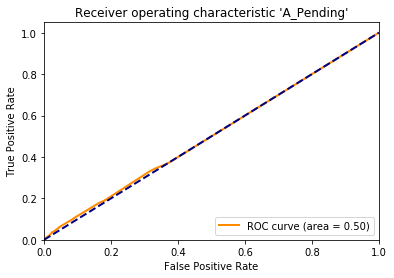

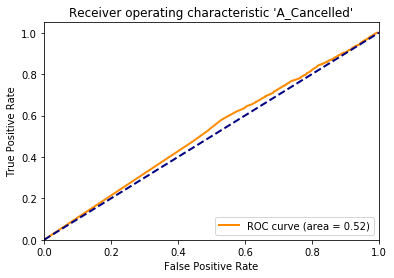

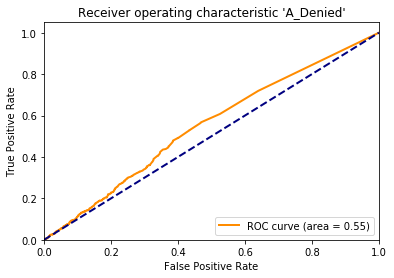

==================== prefix length =  10 ==========================
distribution of test elements:  [1, 109, 4935, 661]
  1  109  4935  661

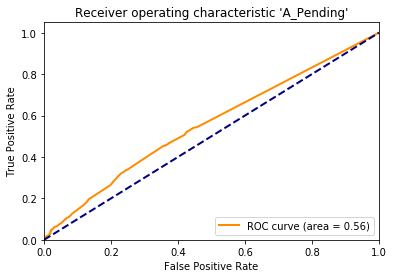

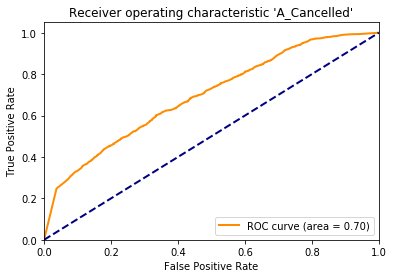

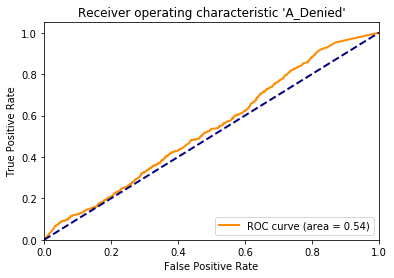

==================== prefix length =  15 ==========================
distribution of test elements:  [129, 149, 1513, 1653, 733, 1529]
  129  149  1513  1653  733  1529

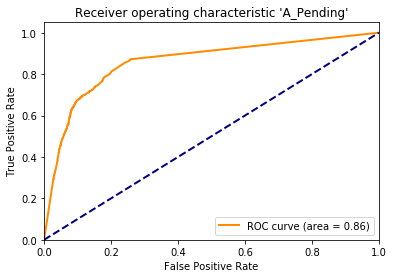

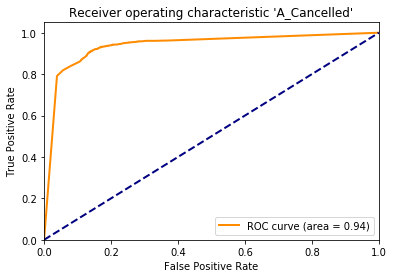

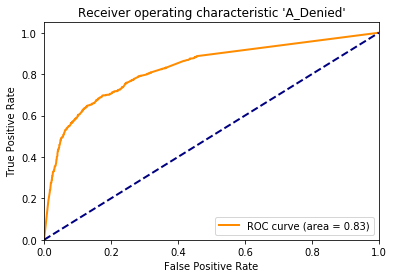

==================== prefix length =  20 ==========================
distribution of test elements:  [197, 109, 996, 129, 2073, 1020, 1182]
  197  109  996  129  2073  1020  1182

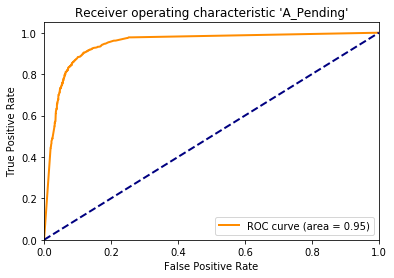

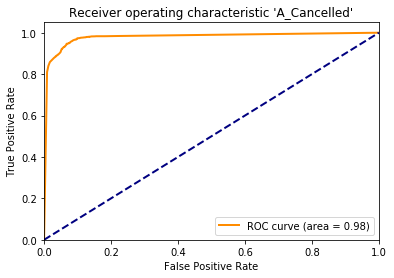

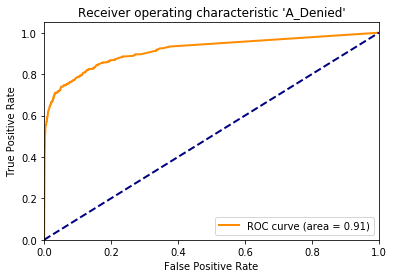

==================== prefix length =  25 ==========================
distribution of test elements:  [124, 101, 994, 145, 2207, 1016, 1119]
  124  101  994  145  2207  1016  1119

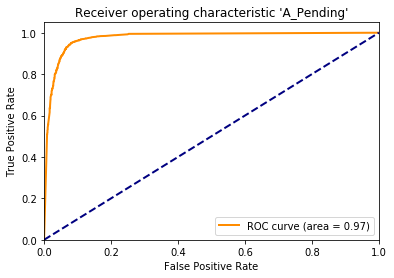

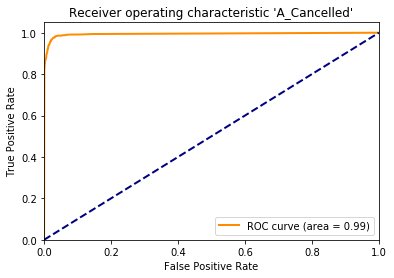

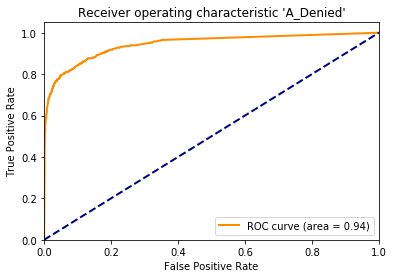

==================== prefix length =  all ==========================
distribution of test elements:  [95, 94, 994, 82, 2284, 1043, 1114]
  95  94  994  82  2284  1043  1114

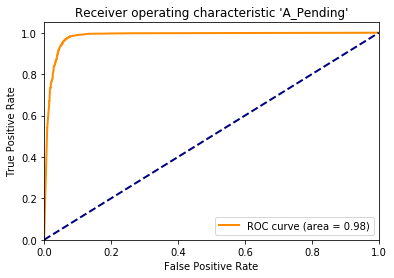

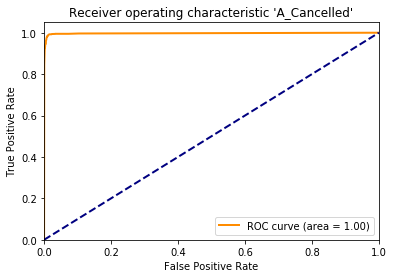

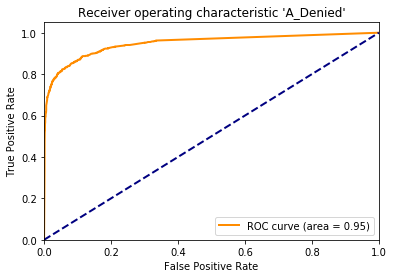

In [275]:
# 6 cluster with correcting: there are no clusters with less than 100 cases for traning min sim=95%

for prefix in list([5,10,15,20,25,'all']):
    print('==================== prefix length = ',prefix,'==========================')
    predict_outcome(test_KMedoide,n=prefix)

In [278]:
g=data.groupby(['Case ID']).apply(lambda x:len(x)).std()

In [277]:
g

17.080576867976188

In [279]:
g

5.613955243118135

# model discovery

In [323]:
# trim first n activity
#######################

n=16
#n_events=test_KMedoide.groupby(['Case ID']).apply(lambda x: cut(x,n)).droplevel(0)
n_events=test_KMedoide.groupby(['Case ID']).apply(lambda x: x.head(n)).droplevel(0)

In [324]:
n_events.to_csv('sequence matcher 7 clusters/8-12-16-20-24/16/test.csv',sep=';')

In [36]:
#Inductive visual miner for all clusters: "Generate petri-net model for each cluster

In [37]:
#alignment test with all clusters  ProM 6: "Alignment Xlog for DPN"

In [38]:
#convert xes alignment file to csv (Disco  --> export csv)

In [339]:
# array of fitnesses
fitnesses=[]
for i in range(len(med)):
    name='sequence matcher 7 clusters/8-12-16-20-24/16/without/align_test_'+str(i)+'.csv'
    alt=pd.read_csv(name,sep=";")
    alt_grouped=alt.groupby(['Case ID'],sort=False).apply(lambda x:x.head(1)).droplevel(1)
    fitnesses.append(alt_grouped[alt_grouped['Case ID'].isin(test_KMedoide['Case ID'].unique())]['(case) alignment:fitness'])

In [340]:
#max fitness --> assignment clusters array
test_cases=list(test_KMedoide['Case ID'].unique())
clusters_assignment=[]
c=[]
for i in range(len(test_cases)):
    fit=[]
    for j in range(len(med)): #testing if a case is exist in all alignment results
        if test_cases[i] in(list(fitnesses[j].index)):
            fit.append(fitnesses[j][fitnesses[j].index==test_cases[i]].values[0])
        
        else:
            print( 'Debugging: Case ',test_cases[i],' not found in model ',j, end='\r')
            break
    if len(fit)==len(med):
        clusters_assignment.append(np.argmax(fit))
        c.append(test_cases[i])

print('Debugging Done!', end='')

Debugging Done!  Application_1229851589  not found in model  0 Application_1049543561  not found in model  0 Application_593154546  not found in model  0 Application_893306042  not found in model  0 not found in model  0 not found in model  0 Application_628997496  not found in model  0Application_1993690110  not found in model  0  not found in model  0Application_1271842045  not found in model  0 Application_1322558151  not found in model  0Application_1349492321  not found in model  0 not found in model  0

In [341]:
# predicting outcome classes
cols = [case_id_col]+list(['A_Pending']+['A_Cancelled']+['A_Denied'])
# important to sort as xes log
cases_frame=pd.DataFrame(c, columns=['Case ID'])
preds = pd.DataFrame(columns=cols)
actual = pd.DataFrame(columns=cols)
print('Distibution of clusters: ',end='')
for cl in range(len(med)):
    # select cases belonging to given cluster
    cases =list( cases_frame[np.array(clusters_assignment) == cl]['Case ID'])
    if len(cases)>0:
        tmp = test_KMedoide[test_KMedoide[case_id_col].isin (cases)]

        # encode data attributes
        test_encode = data_encoder.transform(tmp)
        missing_columns=[col for col in cls_features if col not in test_encode.columns]#test_encode.columns
        mc=pd.DataFrame(columns=missing_columns)
        test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
        test_encode.fillna(0, inplace=True)
        # make predictions
        new_preds = pd.DataFrame(clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
        new_preds.columns =clss[cl].classes_
        new_preds[case_id_col] = list(cases)
        #new_preds
        preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)
        # extract actual label values
        actuals = pd.get_dummies(test_encode[label_col])
        #print(actuals)
        actuals[case_id_col] = test_encode[case_id_col]
        actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
        print(' ',len(new_preds),end='')
    else:
        print(' 0',end='')
print('')
preds.fillna(0, inplace=True)
actual.fillna(0, inplace=True)

Distibution of clusters:   1617  414  27  270  272  219  10


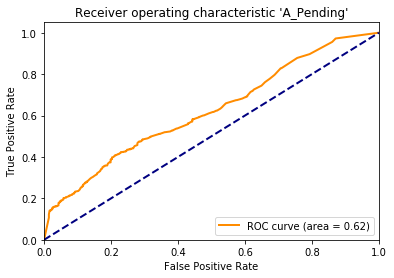

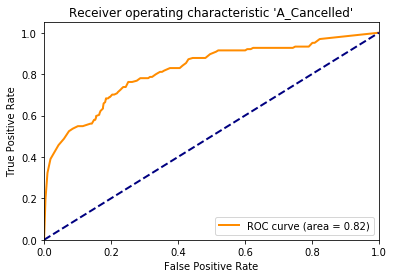

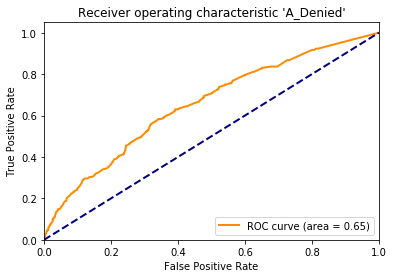

In [342]:
# Before randomly choice multi-max fitness

import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

In [343]:
#max fitness --> assignment clusters array
test_cases=list(test_KMedoide['Case ID'].unique())
clusters_assignment=[]
c=[]
for i in range(len(test_cases)):
    fit=[]
    for j in range(len(med)): #testing if a case is exist in all alignment results
        if test_cases[i] in(list(fitnesses[j].index)):
            fit.append(fitnesses[j][fitnesses[j].index==test_cases[i]].values[0])
        
        else:
            print( 'Debugging: Case ',test_cases[i],' not found in model ',j, end='\r')
            break
    if len(fit)==len(med):
        mx=np.argmax(fit)
        maxf=fit[mx]
        maxes=[]
        for m in range (len(fit)):
            if fit[m]==maxf:
                maxes.append(m)    # in case of several model fit maximum
        al=random.choice(maxes)
        clusters_assignment.append(al)
        c.append(test_cases[i])
print('', end='\r')
print('Debugging Done!', end='')

Debugging Done!  Application_1229851589  not found in model  00 Application_519672671  not found in model  0 0 Application_825032429  not found in model  0Application_1247358786  not found in model  0 Application_1177661137  not found in model  0Application_312076466  not found in model  0 not found in model  00 not found in model  0 not found in model  0  not found in model  0 0 not found in model  0 0 Application_587158528  not found in model  0 00  not found in model  0

In [344]:
# predicting outcome classes
cols = [case_id_col]+list(['A_Pending']+['A_Cancelled']+['A_Denied'])
# important to sort as xes log
cases_frame=pd.DataFrame(c, columns=['Case ID'])
preds = pd.DataFrame(columns=cols)
actual = pd.DataFrame(columns=cols)
print('Distibution of clusters: ',end='')
for cl in range(len(med)):
    # select cases belonging to given cluster
    cases =list( cases_frame[np.array(clusters_assignment) == cl]['Case ID'])
    if len(cases)>0:
        tmp = test_KMedoide[test_KMedoide[case_id_col].isin (cases)]

        # encode data attributes
        test_encode = data_encoder.transform(tmp)
        missing_columns=[col for col in cls_features if col not in test_encode.columns]#test_encode.columns
        mc=pd.DataFrame(columns=missing_columns)
        test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
        test_encode.fillna(0, inplace=True)
        # make predictions
        new_preds = pd.DataFrame(clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
        new_preds.columns =clss[cl].classes_
        new_preds[case_id_col] = list(cases)
        #new_preds
        preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)
        # extract actual label values
        actuals = pd.get_dummies(test_encode[label_col])
        #print(actuals)
        actuals[case_id_col] = test_encode[case_id_col]
        actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
        print(' ',len(new_preds),end='')
    else:
        print(' 0',end='')
print('')
preds.fillna(0, inplace=True)
actual.fillna(0, inplace=True)

Distibution of clusters:   1617  414  27  270  272  219  10


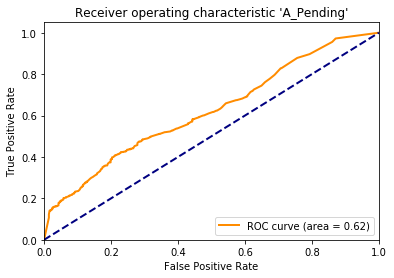

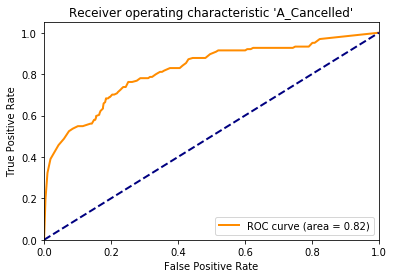

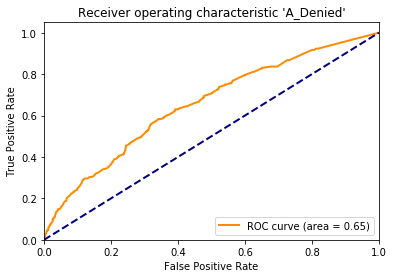

In [345]:
# After randomly choice multi-max fitness

import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# end,

# this part for remaining time prediction: BETA!

## Prediction through Sklearn

In [138]:
import os
from pm4py.objects.log.importer.xes import factory as xes_importer
log = xes_importer.import_log("data/train_0.xes")

In [119]:
test_log = xes_importer.import_log("data/trim.xes")

In [139]:
from pm4py.algo.prediction import factory as prediction_factory
model = prediction_factory.train(log, variant="elasticnet")

In [140]:
results = prediction_factory.test(model, test_log)
#print("ELASTICNET RESULTS")
#print(results)

## Prediction through Sklearn

In [138]:
import os
from pm4py.objects.log.importer.xes import factory as xes_importer
log = xes_importer.import_log("data/train_0.xes")

In [119]:
test_log = xes_importer.import_log("data/trim.xes")

In [139]:
from pm4py.algo.prediction import factory as prediction_factory
model = prediction_factory.train(log, variant="elasticnet")

In [140]:
results = prediction_factory.test(model, test_log)
#print("ELASTICNET RESULTS")
#print(results)

## Prediction through Recurrent Neural Networks (Keras)

In [36]:
from pm4py.algo.prediction import factory as prediction_factory
model = prediction_factory.train(log, variant="keras_rnn")

C:\Users\MSI\Miniconda3\envs\ch\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 568 samples, validate on 143 samples
Epoch 1/50
568/568 [==============================] - 5s 9ms/step - loss: 0.8624 - val_loss: 0.8207
Epoch 2/50
568/568 [==============================] - 1s 2ms/step - loss: 0.6302 - val_loss: 0.3733
Epoch 3/50
568/568 [==============================] - 1s 2ms/step - loss: 0.3175 - val_loss: 0.2517
Epoch 4/50
568/568 [==============================] - 1s 2ms/step - loss: 0.2210 - val_loss: 0.1893
Epoch 5/50
568/568 [==============================] - 1s 2ms/step - loss: 0.1739 - val_loss: 0.1617
Epoch 6/50
568/568 [==============================] - 1s 2ms/step - loss: 0.1537 - val_loss: 0.1524
Epoch 7/50
568/568 [==============================] - 1s 2ms/step - loss: 0.1460 - val_loss: 0.1477
Epoch 8/50
568/568 [==============================] - 1s 2ms/step - loss: 0.1436 - val_loss: 0.1473
Epoch 9/50
568/568 [==============================] - 1s 2ms/step - loss: 0.1433 - val_loss: 0.1467
Epoch 10/50
568/568 [==============================] -

In [119]:
test_log = xes_importer.import_log("data/trim.xes")

In [120]:
rnn_results = prediction_factory.test(model, test_log)
#print("KERAS_RNN results")
#print(rnn_results)

In [ ]:
import pandas
rnn_results=pandas.core.series.Series(rnn_results)
type(rnn_results)
rnn_results.index=ex.index

In [114]:
# trim first n activity
#######################

n=5
trim=pd.read_csv('data/train_0.csv',sep=';',index_col=[0])
n_events=trim.groupby(['Case ID'],sort=False).apply(lambda x: x.head(n)).droplevel(0)

n_events.to_csv('data/trim.csv',sep=';')


In [143]:
results=pandas.core.series.Series(results)
type(results)
results.index=ex.index
results

Case ID
Application_1966208034    231331.561143
Application_1111870538    183596.659596
Application_1461440233    183596.659596
Application_857715587     183596.659596
Application_798605556     183596.659596
Application_74089970       68291.419446
Application_1363165385    231331.561143
Application_1386615618    183596.659596
Application_714015178     188895.340193
Application_1793939874    222802.595800
Application_1231200933     68291.419446
Application_448701611     193835.041017
Application_1111090727     68291.419446
Application_1158965741    183596.659596
Application_1793665913    231331.561143
Application_570833369     142818.193146
Application_479369766     193835.041017
Application_787459470     183596.659596
Application_497612234     183596.659596
Application_290531407      68291.419446
Application_495055221      68291.419446
Application_1358464831     68291.419446
Application_1213984554    183596.659596
Application_148281004     183596.659596
Application_268737670     183596

In [141]:
rnn_results

Case ID
Application_1966208034    697766.301850
Application_1111870538    693335.130577
Application_1461440233    693335.130577
Application_857715587     693335.130577
Application_798605556     693335.130577
Application_74089970      640487.740699
Application_1363165385    697766.301850
Application_1386615618    693335.130577
Application_714015178     694083.897293
Application_1793939874    668334.714616
Application_1231200933    640487.740699
Application_448701611     657170.385181
Application_1111090727    640487.740699
Application_1158965741    693335.130577
Application_1793665913    697766.301850
Application_570833369     662676.481599
Application_479369766     657170.385181
Application_787459470     693335.130577
Application_497612234     693335.130577
Application_290531407     640487.740699
Application_495055221     640487.740699
Application_1358464831    640487.740699
Application_1213984554    693335.130577
Application_148281004     693335.130577
Application_268737670     693335

In [51]:
def execution_time(x):#for one case
    t=x['Start Timestamp'][x.index.min()]
    t = time.strptime(t, "%Y/%m/%d %H:%M:%S.%f")
    t2=x['Complete Timestamp'][x.index.max()]
    t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
    exe=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
    return (86400 * exe.days + exe.seconds)

In [55]:
from datetime import datetime, timedelta

In [101]:
avg_grouping=trim.groupby(['Case ID'],sort=False)
ex=avg_grouping.apply(lambda x: execution_time(x))
#avg=ex.mean()
        

In [134]:
ex/86400

Case ID
Application_1966208034    31.578831
Application_1111870538     6.615544
Application_1461440233    57.675150
Application_857715587     30.667245
Application_798605556      8.808565
Application_74089970       1.805359
Application_1363165385     5.138866
Application_1386615618     4.999537
Application_714015178     52.742801
Application_1793939874    36.618646
Application_1231200933    49.481667
Application_448701611     31.513519
Application_1111090727    31.484850
Application_1158965741    44.695741
Application_1793665913    43.605451
Application_570833369     12.203843
Application_479369766     41.571447
Application_787459470     40.923912
Application_497612234     32.749803
Application_290531407     31.886979
Application_495055221     32.633009
Application_1358464831    31.480220
Application_1213984554    35.458646
Application_148281004     33.881910
Application_268737670     37.786157
Application_993168875     31.430822
Application_1231253515    35.531933
Application_12526664

In [103]:
#n_events['Case ID']=n_events.index
#n_events.index=range(0,len(n_events))
avg_grouping_n=n_events.groupby(['Case ID'],sort=False)
ex_n=avg_grouping_n.apply(lambda x: execution_time(x))
#avg=ex.mean()
        

In [135]:
ex_n/86400

Case ID
Application_1966208034     0.944745
Application_1111870538     2.541725
Application_1461440233     1.782720
Application_857715587      0.004537
Application_798605556      1.020949
Application_74089970       1.796470
Application_1363165385     1.138194
Application_1386615618     3.622546
Application_714015178     21.073889
Application_1793939874     5.795509
Application_1231200933     1.645301
Application_448701611      0.762049
Application_1111090727     0.742245
Application_1158965741     0.043449
Application_1793665913     1.711262
Application_570833369      1.510961
Application_479369766      0.654479
Application_787459470      0.003877
Application_497612234      1.838102
Application_290531407      1.074039
Application_495055221      1.821505
Application_1358464831     0.744259
Application_1213984554     0.497546
Application_148281004      2.927801
Application_268737670      0.006505
Application_993168875      0.798102
Application_1231253515     0.555567
Application_12526664

In [137]:
rnn_results/86400

Case ID
Application_1966208034    8.075999
Application_1111870538    8.024712
Application_1461440233    8.024712
Application_857715587     8.024712
Application_798605556     8.024712
Application_74089970      7.413053
Application_1363165385    8.075999
Application_1386615618    8.024712
Application_714015178     8.033378
Application_1793939874    7.735355
Application_1231200933    7.413053
Application_448701611     7.606139
Application_1111090727    7.413053
Application_1158965741    8.024712
Application_1793665913    8.075999
Application_570833369     7.669867
Application_479369766     7.606139
Application_787459470     8.024712
Application_497612234     8.024712
Application_290531407     7.413053
Application_495055221     7.413053
Application_1358464831    7.413053
Application_1213984554    8.024712
Application_148281004     8.024712
Application_268737670     8.024712
Application_993168875     8.024712
Application_1231253515    7.670878
Application_1252666486    8.075999
Application_

In [136]:
(ex-ex_n)/86400

Case ID
Application_1966208034    30.634086
Application_1111870538     4.073819
Application_1461440233    55.892431
Application_857715587     30.662708
Application_798605556      7.787616
Application_74089970       0.008889
Application_1363165385     4.000671
Application_1386615618     1.376991
Application_714015178     31.668912
Application_1793939874    30.823137
Application_1231200933    47.836366
Application_448701611     30.751470
Application_1111090727    30.742604
Application_1158965741    44.652292
Application_1793665913    41.894190
Application_570833369     10.692882
Application_479369766     40.916968
Application_787459470     40.920035
Application_497612234     30.911701
Application_290531407     30.812940
Application_495055221     30.811505
Application_1358464831    30.735961
Application_1213984554    34.961100
Application_148281004     30.954109
Application_268737670     37.779653
Application_993168875     30.632720
Application_1231253515    34.976366
Application_12526664

In [144]:
results/86400

Case ID
Application_1966208034    2.677449
Application_1111870538    2.124961
Application_1461440233    2.124961
Application_857715587     2.124961
Application_798605556     2.124961
Application_74089970      0.790410
Application_1363165385    2.677449
Application_1386615618    2.124961
Application_714015178     2.186289
Application_1793939874    2.578734
Application_1231200933    0.790410
Application_448701611     2.243461
Application_1111090727    0.790410
Application_1158965741    2.124961
Application_1793665913    2.677449
Application_570833369     1.652988
Application_479369766     2.243461
Application_787459470     2.124961
Application_497612234     2.124961
Application_290531407     0.790410
Application_495055221     0.790410
Application_1358464831    0.790410
Application_1213984554    2.124961
Application_148281004     2.124961
Application_268737670     2.124961
Application_993168875     2.124961
Application_1231253515    2.099553
Application_1252666486    2.677449
Application_

# centeroid

# now lest test our model:

In [59]:
# fit finished
#then predict:

In [356]:
def predict_outcome(test_KMedoide,n='all'):
    
    if n=='all':
        n_events=test_KMedoide
        
    # trim first n activity
    #######################
    else:
        #n_events=test_KMedoide.groupby(['Case ID'],sort=False).apply(lambda x: x.head(n)).droplevel(0)
        n_events=test_KMedoide.groupby(['Case ID'],sort=False).apply(lambda x: cut(x,n)).droplevel(0)
    tot=len(test_KMedoide['Case ID'].unique())
    print("Prediction for ",len(n_events['Case ID'].unique()),'/',tot,' cases')


    ascii_offset=161

    # aggregate activities by case
    grouped = n_events.groupby(['Case ID'], sort=False)

    # extract  encoded trace from actvities
    Activities_test = grouped.apply(lambda x: trace(x) )

    labels = n_events.groupby(['Case ID'],sort=False).first()['lbl']

    ac_lbl_test=pd.DataFrame(columns=['Case ID','Activity','lbl'])
    ac_lbl_test['Case ID']=Activities_test.index
    ac_lbl_test['Activity']=list(Activities_test)
    ac_lbl_test['lbl']=list(labels)

    # encoding name of cluster implicitely cluster name = np.argmax(sim)  it may neglagate a cluster if not max anytime!!


    clustered_test=[]

    for i in  range(ac_lbl_test.shape[0]) :
        sim=[]
        for j in range(len(medoide_table)):
            sim.append(diff.SequenceMatcher(None,ac_lbl_test['Activity'][i],medoide_table['Activity'][j]).ratio())
        clustered_test.append(np.argmax(sim))
    clusters_names=np.unique(clustered_test)

    print('distribution of test elements: ', [clustered_test.count(k) for k in clusters_names ])

    # predict outcomes for each cluster
    cols = ['Case ID']+list(['A_Pending','A_Cancelled','A_Denied'])#list(clss[0].classes_)
    preds = pd.DataFrame(columns=cols)
    actual = pd.DataFrame(columns=cols)
    cluster_assignments=np.array(clustered_test )

    for cl in clusters_names:

        cases = ac_lbl_test[cluster_assignments == cl]['Case ID']
        tmp = n_events[n_events[case_id_col].isin(cases)]
        test_encode = data_encoder.transform(tmp)

        missing_columns=[col for col in cls_features if col not in cls_features]
        mc=pd.DataFrame(columns=missing_columns)
        test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
        test_encode.fillna(0, inplace=True)

        new_preds = pd.DataFrame(clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
        new_preds.columns = clss[cl].classes_
        new_preds[case_id_col] = list(test_encode['Case ID'])
        preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)

        actuals = pd.get_dummies(test_encode[label_col])
        actuals[case_id_col] = test_encode[case_id_col]
        actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
        print(' ',len(new_preds),end='')


    preds.fillna(0, inplace=True)
    actual.fillna(0, inplace=True)

    import sklearn.metrics as met
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    th=dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(3):
        plt.figure()
        lw = i
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
        plt.legend(loc="lower right")
        plt.show()
    return;

In [283]:
def cut(x,n):
    if len(x)>n:
        return x.head(n)
    else:
        return;

# save this

==================== prefix length =  8 ==========================
Prediction for  5692 / 5706  cases
distribution of test elements:  [5197, 495]
  5197  495

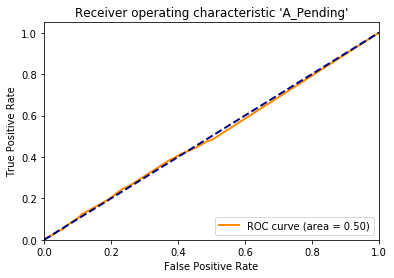

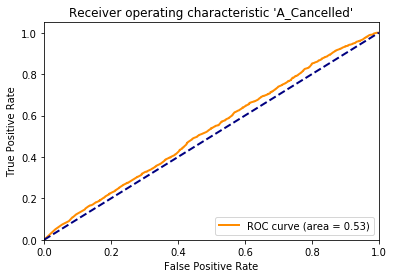

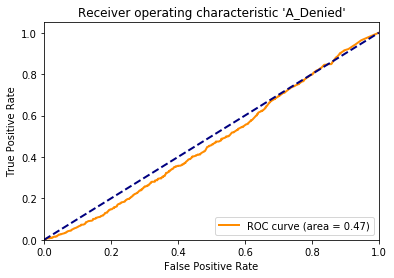

==================== prefix length =  12 ==========================
Prediction for  4380 / 5706  cases
distribution of test elements:  [14, 137, 3229, 1000]
  14  137  3229  1000

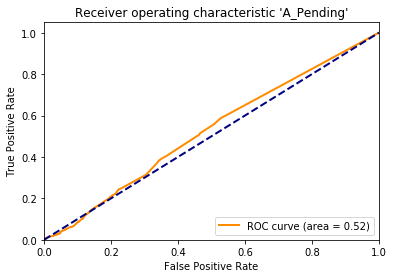

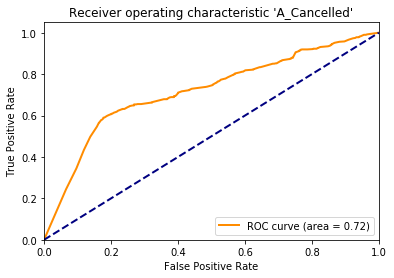

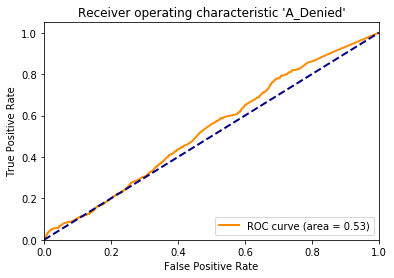

==================== prefix length =  16 ==========================
Prediction for  2839 / 5706  cases
distribution of test elements:  [94, 97, 289, 3, 1222, 732, 402]
  94  97  289  3  1222  732  402

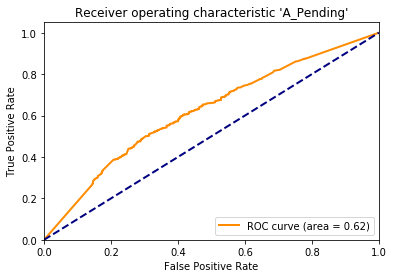

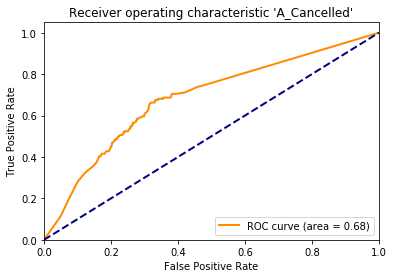

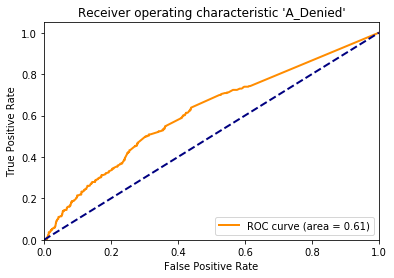

==================== prefix length =  20 ==========================
Prediction for  1343 / 5706  cases
distribution of test elements:  [131, 31, 3, 120, 647, 331, 80]
  131  31  3  120  647  331  80

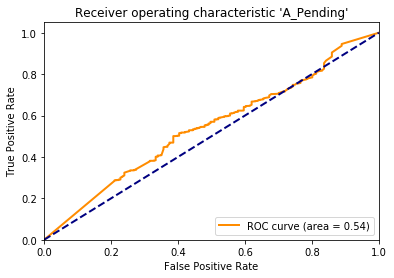

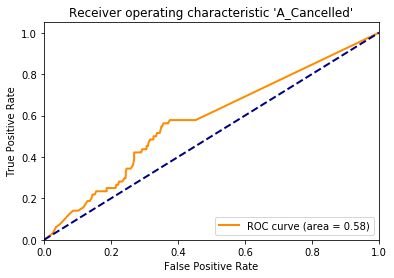

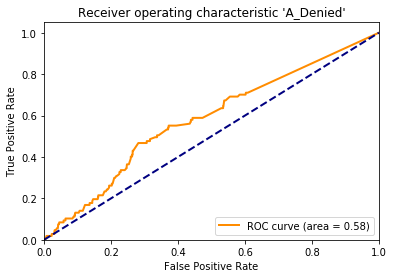

==================== prefix length =  24 ==========================
Prediction for  587 / 5706  cases
distribution of test elements:  [55, 16, 135, 272, 102, 7]
  55  16  135  272  102  7

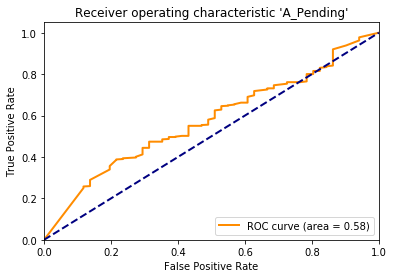

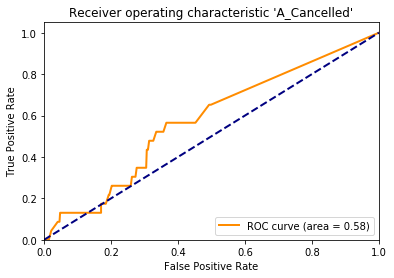

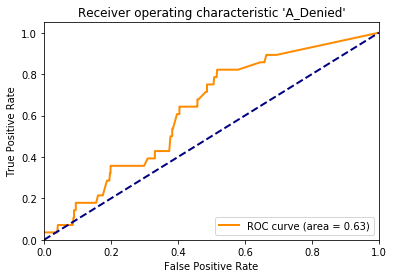

==================== prefix length =  all ==========================
Prediction for  5706 / 5706  cases
distribution of test elements:  [95, 94, 994, 82, 2284, 1043, 1114]
  95  94  994  82  2284  1043  1114

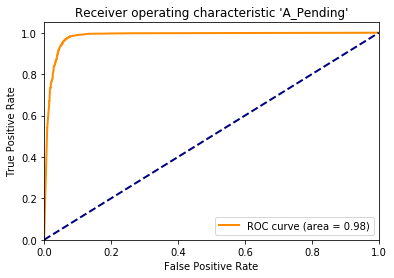

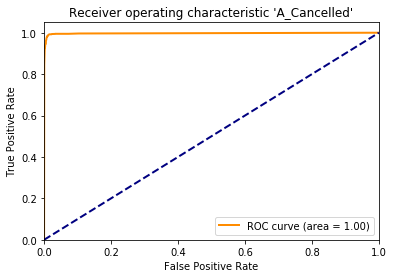

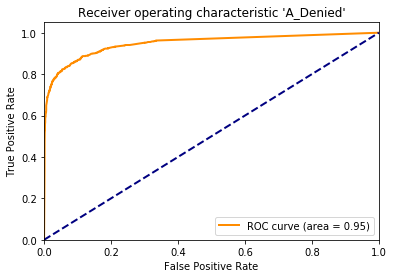

In [357]:
# 7 clusters
# no failure cases
for prefix in list([8,12,16,20,24,'all']):
    print('==================== prefix length = ',prefix,'==========================')
    predict_outcome(test_KMedoide,n=prefix)

==================== prefix length =  8 ==========================
distribution of test elements:  [5206, 500]
  5206  500

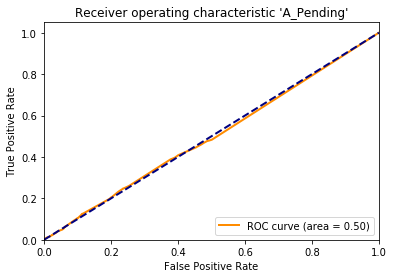

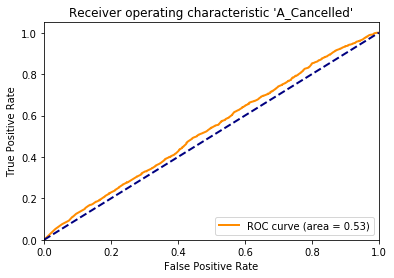

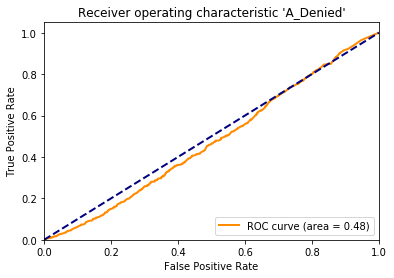

==================== prefix length =  12 ==========================
distribution of test elements:  [14, 138, 3760, 1794]
  14  138  3760  1794

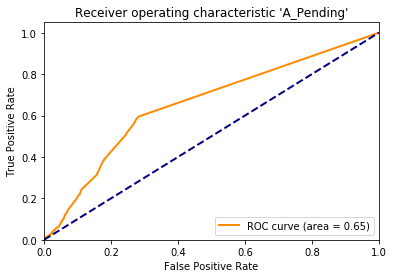

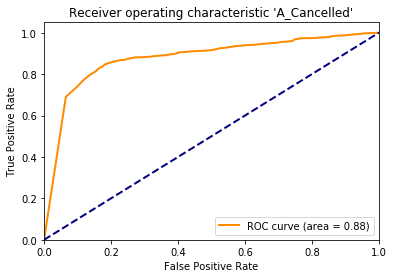

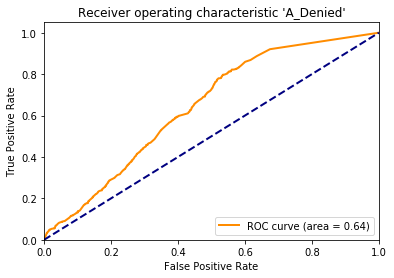

==================== prefix length =  16 ==========================
distribution of test elements:  [133, 155, 1213, 3, 1750, 988, 1464]
  133  155  1213  3  1750  988  1464

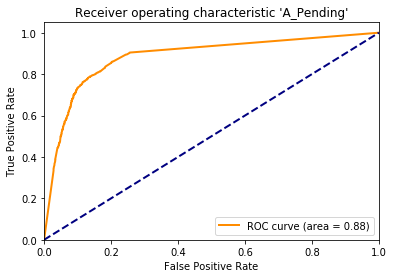

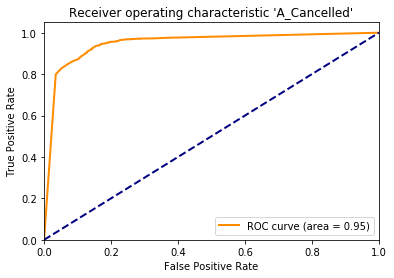

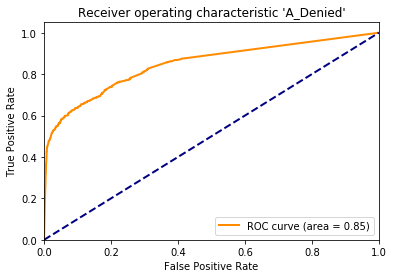

==================== prefix length =  20 ==========================
distribution of test elements:  [197, 109, 996, 129, 2073, 1020, 1182]
  197  109  996  129  2073  1020  1182

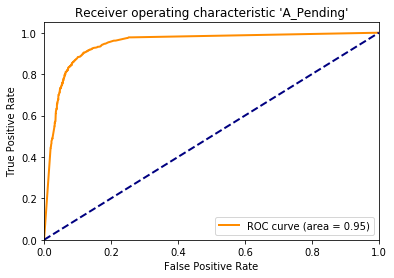

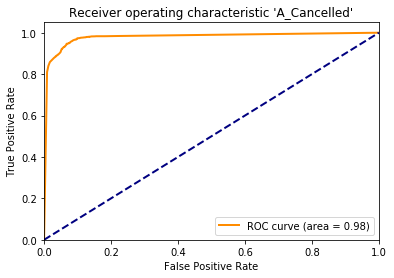

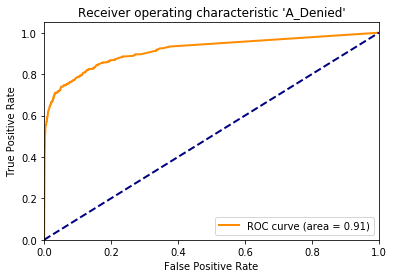

==================== prefix length =  24 ==========================
distribution of test elements:  [135, 104, 994, 162, 2181, 1009, 1121]
  135  104  994  162  2181  1009  1121

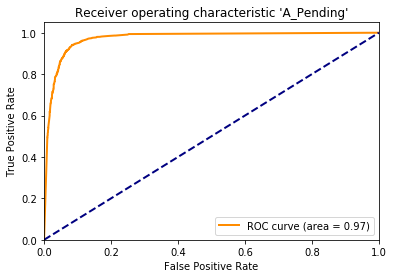

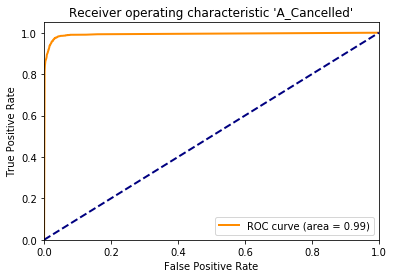

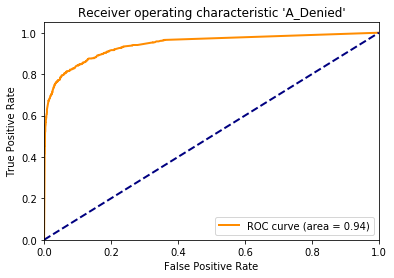

==================== prefix length =  all ==========================
distribution of test elements:  [95, 94, 994, 82, 2284, 1043, 1114]
  95  94  994  82  2284  1043  1114

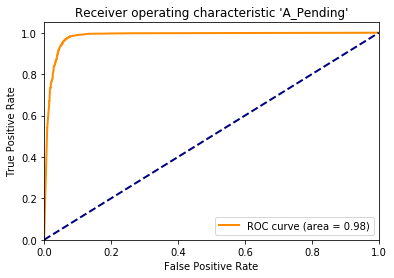

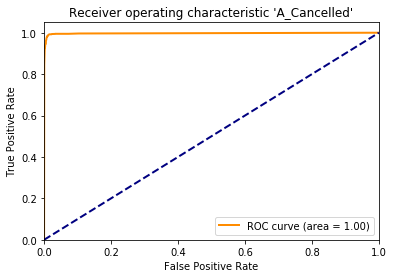

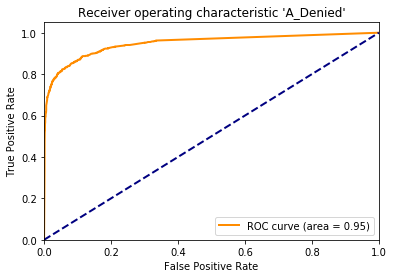

In [355]:
# 7 clusters
# with failure cases
for prefix in list([8,12,16,20,24,'all']):
    print('==================== prefix length = ',prefix,'==========================')
    predict_outcome(test_KMedoide,n=prefix)

# all

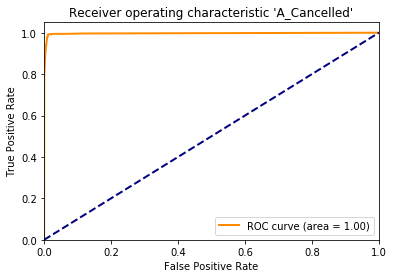

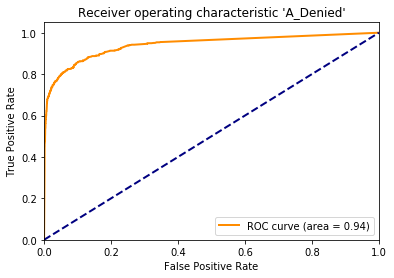

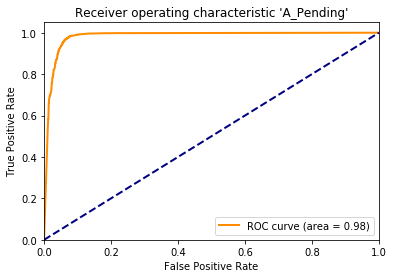

In [130]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# End file,